# Structure

* ### [Device Set Up](#device)
* ### [Dataset](#data)
* ### [Fully Connected Autoencoder](#fc_encoder)
* ### [Fully Convolutional Autoencoder](#c_autoencoder)

In [108]:
# Imports

import numpy as np

from torchvision import datasets, transforms
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

import os

In [109]:
# Seed
def set_seed(seed):
    """
    The function that sets a random seed to ensure the reproducibility of any randomized processes
    """

    np.random.seed(seed)
    torch.manual_seed(seed)

#### <a id='device'>Device Set up</a>

##### MacOS Apple Silicon GPU

In [110]:
#! pip3 install torch torchvision torchaudio
# Connect GPU
device = torch.device("mps")

##### Google Colab GPU

In [111]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### <a id='data'> Dataset </a>

In [112]:
class FlattenTransform():

    def __call__(self, tensor):
        return tensor.view(-1)

mnist_transform = transforms.Compose([transforms.ToTensor(),  # convert the image to a tensor
                                      transforms.Normalize((0.5), (0.5)),  # normalize                
                                      FlattenTransform()])  # flatten the tensor

# transformation are applied dynamically on the retrieval of individual items
train_dataset = datasets.MNIST(root = './data', train = True, transform = mnist_transform, download = True)
test_dataset = datasets.MNIST(root = './data', train = False, transform = mnist_transform, download = True)

#### <a id='fc_encoder'> Fully Connected Autoencoder </a>

In [113]:
# Model
class FCAutoEncoder(nn.Module):
    """
    Fully Connected Autoencoder
    """

    def __init__(self, in_dim, out_dim):
        super(FCAutoEncoder, self).__init__()


        self.encoder = nn.Sequential(nn.Linear(in_dim, 324),
                                      nn.BatchNorm1d(324),
                                      nn.LeakyReLU(),
                                      nn.Linear(324, 64),
                                      nn.BatchNorm1d(64),
                                      nn.LeakyReLU())

        self.decoder = nn.Sequential(nn.Linear(64, 324),
                                      nn.BatchNorm1d(324),
                                      nn.LeakyReLU(),
                                      nn.Linear(324, out_dim),
                                      nn.BatchNorm1d(out_dim),
                                      nn.Tanh())

        # Initialize weights
        self._initialize_weights()


    def _initialize_weights(self):

        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode = 'fan_out', nonlinearity = 'leaky_relu')

                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)


    def forward(self, x):

        x1 = self.encoder(x)
        output = self.decoder(x1)

        return output

In [114]:
# Model Trainer Class

class FCNNTrainer:
    def __init__(self, lr: int, model: nn.Module, device):
        set_seed(9)

        self.device = device
        self.criterion = nn.MSELoss()
        self.model = model
        self.optimizer_name = None
        self.optimizer = None
        self.lr = lr
        self.epochs = None
        self.train_loader = None
        self.test_loader = None
        self.train_metrics = []
        self.test_metrics = []
        self.models_dir = "./models_states"


    def set_optimizer(self, optimizer_name: str, optimizer_func):
        self.optimizer = optimizer_func(self.model.parameters(), lr=self.lr)
        self.optimizer_name = optimizer_name

    def set_epochs(self, epochs: int):
        self.epochs = epochs

    def prepare_loaders(self, train_dataset, test_dataset, batch_size: int) -> dict:
        train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
        test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True)

        self.train_loader = train_loader
        self.test_loader = test_loader

        return {
            "train": train_loader,
            "test": test_loader
        }

    def __optimize_weights(self) -> float:
        self.model.train()
        total_loss = 0
        for x_tr, _ in self.train_loader:
            x_tr = x_tr.to(self.device)
            outputs = self.model(x_tr)
            loss = self.criterion(outputs, x_tr)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(self.train_loader)

    def __count_test_loss(self) -> float:
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for x_ts, _ in self.test_loader:
                x_ts = x_ts.to(self.device)
                outputs = self.model(x_ts)
                loss = self.criterion(outputs, x_ts)
                total_loss += loss.item()


        return total_loss / len(self.test_loader)

    def epoch_train(self, epoch_val: int, prev_epochs: int, benchmark_mse: float):
        best_mse = float("inf")
        for epoch in range(epoch_val):
            train_loss = self.__optimize_weights()
            self.train_metrics.append(train_loss)

            test_loss = self.__count_test_loss()
            self.test_metrics.append(test_loss)

            self.__save_parameters(epoch=epoch, prev_epochs=prev_epochs,
                                   model_name=f"{self.model.__class__.__name__}_{self.optimizer_name}")

            print(f'Train Epoch: {epoch} \t [Train Loss]: {train_loss:.6f} \t [Test Loss]: {test_loss:.6f} \t')

            if test_loss < best_mse:
                best_mse = test_loss
                if best_mse <= benchmark_mse:
                    print(f"Reached {benchmark_mse} MSE value at epoch {epoch + 1}")
                    return epoch + 1


    def plot_metrics(self, epochs: int):
        plt.figure(figsize=(10, 5))
        plt.plot(range(epochs), self.train_metrics, label='Training Loss')
        plt.plot(range(epochs), self.test_metrics, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Cross')
        plt.title(f"Training and Validation MSE over Epochs via {self.optimizer_name}")
        plt.legend()
        plt.grid(True)
        plt.show()

    def __save_parameters(self, epoch: int, prev_epochs: int, model_name: str):
        save_path = f'{self.models_dir}/{model_name}/epoch_{epoch + prev_epochs + 1}.pth'

        if not os.path.exists(f'{self.models_dir}/{model_name}'):
            os.makedirs(f'{self.models_dir}/{model_name}')

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_loss': self.train_metrics[epoch + prev_epochs],
            'test_loss': self.test_metrics[epoch + prev_epochs],
        }, save_path)

        if not os.path.exists(save_path):
            raise IOError(f"Failed to save the model at {save_path}")
        
    
    def clear_main_values(self, model, device):
        self.model = model
        self.optimizer_name = None
        self.optimizer = None
        self.epochs = None
        self.train_metrics = []
        self.test_metrics = []

In [115]:
# Model Train Cycle Func

optimizers_list = {
    "Adam": torch.optim.Adam,
}

def train(
              model_class: nn.Module,
              in_dim: int,
              epochs_list: list,
              learning_rate: float,
              train_dataset,
              test_dataset,
              batch_size: int,
              benchmark_mse: float
        ) -> dict:
    # Init model
    model = model_class(in_dim, in_dim).to(device)
    # Init model trainder
    trainer = FCNNTrainer(lr=learning_rate, model=model, device=device)
    # Prepare 
    trainer.prepare_loaders(train_dataset, test_dataset, batch_size)
    best_parameters = {}

    for optimizer_name, optimizer_func in optimizers_list.items():
            trainer.set_optimizer(optimizer_name, optimizer_func)

            # Start training
            for ind, epoch in enumerate(epochs_list):
                    trainer.set_epochs(epoch)
                    success_epoch = trainer.epoch_train(epoch_val=epoch, prev_epochs=sum(epochs_list[:ind]), benchmark_mse=benchmark_mse)

                    trainer.plot_metrics(epochs=success_epoch)

            best_epoch = trainer.test_metrics.index(min(trainer.test_metrics))
            best_epoch += 1 ## Since we count from 0
            best_parameters[optimizer_name] = {"epoch": best_epoch, "min_loss": min(trainer.test_metrics)}
            model = model_class(in_dim, 10)
            trainer.clear_main_values(model, device)
    del trainer, model
    return best_parameters

In [116]:
# Model Test Func

def test_model(model: nn.Module, test_dataset):
    model.eval()
    test_loader = DataLoader(dataset=test_dataset, batch_size=500, shuffle=True)
    with torch.no_grad():

        ### Test dataset ###
        x_ts, _ = next(iter(test_loader))
        x = x_ts[:10]
        x = x.to(device)
        x_pred = model(x)

    x = x.view(10, 28, 28).cpu().numpy()
    x_pred = x_pred.view(10, 28, 28).detach().cpu().numpy()

    fig, axes = plt.subplots(2, 10, figsize=(12, 5))
    for i in range(10):
        # Original
        axes[0, i].imshow(x[i], cmap='gray')
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('off')

        # Predicted
        axes[1, i].imshow(x_pred[i], cmap='gray')
        axes[1, i].set_title(f"Predicted {i+1}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


In [117]:
# Loaders of best model state

def load_model_state(model: nn.Module, optimizer, optimizer_name: str, epoch: int, model_states_dir="./models_states"):
    model_name = f"{model.__class__.__name__}_{optimizer_name}"
    checkpoint_path = f'{model_states_dir}/{model_name}/epoch_{epoch}.pth'
    
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"No such file or directory: '{checkpoint_path}'")

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['train_loss'], checkpoint['test_loss']


def load_best_model(epoch: int, optimizer_name: str, model: nn.Module, in_dim: int, lr: float):
    
    best_model = model(in_dim, in_dim).to(device)
    optimizer = optimizers_list[optimizer_name](best_model.parameters(), lr=lr)
    load_model_state(best_model, optimizer, optimizer_name, epoch)
    return best_model, optimizer

Train Epoch: 0 	 [Train Loss]: 0.785809 	 [Test Loss]: 0.594217 	
Train Epoch: 1 	 [Train Loss]: 0.567604 	 [Test Loss]: 0.510954 	
Train Epoch: 2 	 [Train Loss]: 0.487622 	 [Test Loss]: 0.452313 	
Train Epoch: 3 	 [Train Loss]: 0.426389 	 [Test Loss]: 0.387998 	
Train Epoch: 4 	 [Train Loss]: 0.379255 	 [Test Loss]: 0.338017 	
Train Epoch: 5 	 [Train Loss]: 0.339549 	 [Test Loss]: 0.299562 	
Train Epoch: 6 	 [Train Loss]: 0.306732 	 [Test Loss]: 0.272908 	
Train Epoch: 7 	 [Train Loss]: 0.278115 	 [Test Loss]: 0.254269 	
Train Epoch: 8 	 [Train Loss]: 0.250991 	 [Test Loss]: 0.230301 	
Train Epoch: 9 	 [Train Loss]: 0.230267 	 [Test Loss]: 0.204900 	
Train Epoch: 10 	 [Train Loss]: 0.210981 	 [Test Loss]: 0.178143 	
Train Epoch: 11 	 [Train Loss]: 0.193293 	 [Test Loss]: 0.171459 	
Train Epoch: 12 	 [Train Loss]: 0.179788 	 [Test Loss]: 0.154727 	
Train Epoch: 13 	 [Train Loss]: 0.165739 	 [Test Loss]: 0.151381 	
Train Epoch: 14 	 [Train Loss]: 0.154464 	 [Test Loss]: 0.130204 	
Train

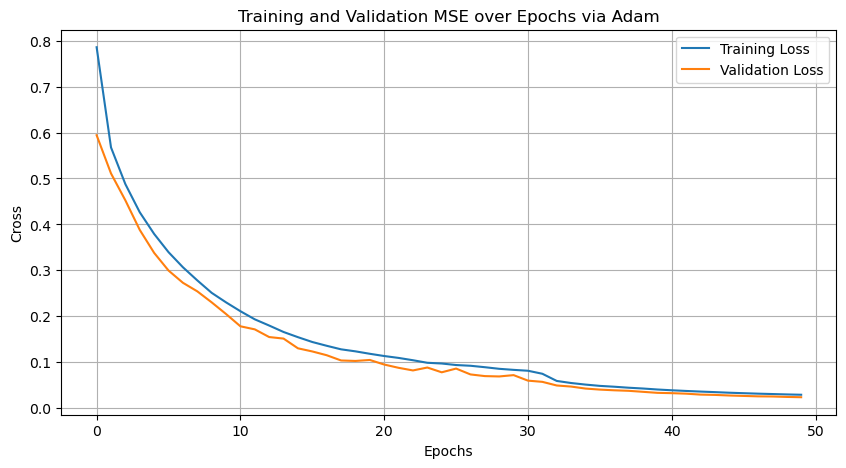

In [118]:
model_class = FCAutoEncoder
in_dim = 28 * 28
lr = 0.0001
epochs_list = [50]
batch_size = 100
benchmark_mse = 0.024


best_parameters = train(
        model_class=model_class,
        in_dim=in_dim,
        epochs_list=epochs_list,
        learning_rate=lr,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        batch_size=batch_size,
        benchmark_mse=benchmark_mse
    )


In [119]:
optimizer_name = min(best_parameters, key=lambda k: best_parameters[k]['min_loss'])
epochs = best_parameters[optimizer_name]['epoch']
model,_ = load_best_model(
    epochs,
    optimizer_name,
    model_class,
    in_dim,
    lr
)

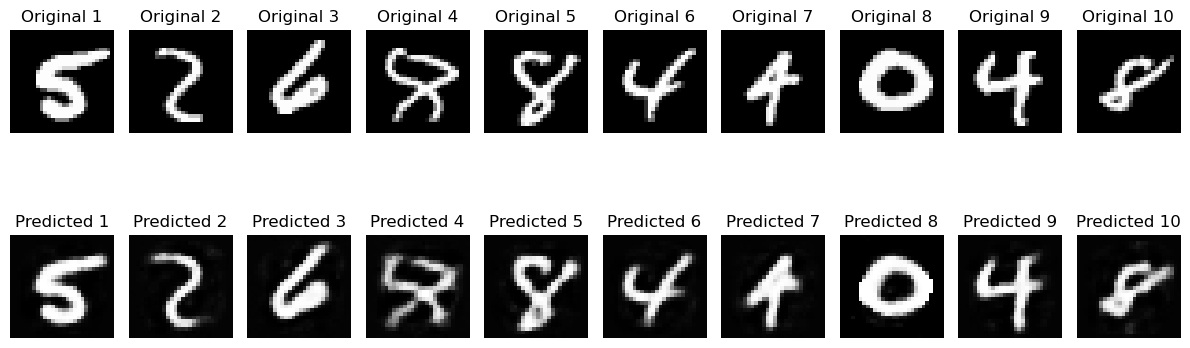

In [120]:
test_model(model, test_dataset)

#### <a id='c_autoencoder'> Fully Convolutional Autoencoder </a>

In [121]:
# Model
class ConvAutoEncoder(nn.Module):
    """
    Fully Convolutional Autoencoder
    """

    def __init__(self, in_dim, out_dim):
        super(ConvAutoEncoder, self).__init__()


        self.encoder = nn.Sequential(nn.Conv2d(in_dim, 32, kernel_size = 3, padding = 1),
                                     nn.BatchNorm2d(32),
                                     nn.LeakyReLU(),
                                     nn.MaxPool2d(kernel_size = 2, stride = 2),
                                     nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
                                     nn.BatchNorm2d(64),
                                     nn.LeakyReLU(),
                                     nn.MaxPool2d(kernel_size = 2, stride = 2),
                                     nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
                                     nn.BatchNorm2d(128),
                                     nn.LeakyReLU(),
                                     nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.decoder = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2),
                                     nn.BatchNorm2d(64),
                                     nn.LeakyReLU(),
                                     nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2),
                                     nn.BatchNorm2d(32),
                                     nn.LeakyReLU(),
                                     nn.ConvTranspose2d(32, out_dim, kernel_size = 2, stride = 2),
                                     nn.Tanh())

        # Initialize weights
        self._initialize_weights()


    def _initialize_weights(self):

        for layer in self.modules():
            if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(layer.weight, mode = 'fan_out', nonlinearity = 'leaky_relu')

                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)


    def forward(self, x):

        x1 = self.encoder(x)
        output = self.decoder(x1)

        return output


In [122]:
# Salt & Pepper Noise Class

class SaltPepperNoise(object):
    def __init__(self, salt_prob, pepper_prob):
        self.salt_prob = salt_prob
        self.pepper_prob = pepper_prob

    def __call__(self, img):
        img_np = img.numpy()
        out = img_np.copy()

        num_salt = np.ceil(self.salt_prob * img_np.size)
        coords = [np.random.randint(0, max(1, i - 1), int(num_salt)) for i in img_np.shape]
        out[tuple(coords)] = 1

        num_pepper = np.ceil(self.pepper_prob * img_np.size)
        coords = [np.random.randint(0, max(1, i - 1), int(num_pepper)) for i in img_np.shape]
        out[tuple(coords)] = 0

        return torch.tensor(out, dtype=torch.float32)
    

def add_noise(images, salt_prob=0.02, pepper_prob=0.02):
        noisy_images = images.clone()
        for i in range(noisy_images.size(0)):
            noisy_images[i] = SaltPepperNoise(salt_prob, pepper_prob)(noisy_images[i])
        return noisy_images

In [123]:
# Model Trainer Class

class FCNNTrainer:
    def __init__(self, lr: int, model: nn.Module, device):
        self.device = device
        self.criterion = nn.MSELoss()
        self.model = model.to(self.device)
        self.optimizer_name = None
        self.optimizer = None
        self.lr = lr
        self.epochs = None
        self.train_loader = None
        self.test_loader = None
        self.train_metrics = []
        self.test_metrics = []
        self.models_dir = "./models_states"

    def set_optimizer(self, optimizer_name: str, optimizer_func):
        self.optimizer = optimizer_func(self.model.parameters(), lr=self.lr)
        self.optimizer_name = optimizer_name

    def set_epochs(self, epochs: int):
        self.epochs = epochs

    def prepare_loaders(self, train_dataset, test_dataset, batch_size: int) -> dict:
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

        self.train_loader = train_loader
        self.test_loader = test_loader

        return {
            "train": train_loader,
            "test": test_loader
        }

    def __optimize_weights(self) -> float:
        self.model.train()
        total_loss = 0
        for x_tr, _ in self.train_loader:
            noisy_x_tr = add_noise(x_tr)
            noisy_x_tr = noisy_x_tr.to(self.device)
            x_tr = x_tr.to(self.device)
            outputs = self.model(noisy_x_tr)
            loss = self.criterion(outputs, x_tr)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(self.train_loader)

    def __count_test_loss(self) -> float:
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for x_ts, _ in self.test_loader:
                noisy_x_ts = add_noise(x_ts)
                x_ts = x_ts.to(self.device)
                noisy_x_ts = noisy_x_ts.to(self.device)
                outputs = self.model(noisy_x_ts)
                loss = self.criterion(outputs, x_ts)
                total_loss += loss.item()
        return total_loss / len(self.test_loader)

    def epoch_train(self, epoch_val: int, prev_epochs: int, benchmark_mse: float):
        best_mse = float("inf")
        for epoch in range(epoch_val):
            train_loss = self.__optimize_weights()
            self.train_metrics.append(train_loss)

            test_loss = self.__count_test_loss()
            self.test_metrics.append(test_loss)

            self.__save_parameters(epoch=epoch, prev_epochs=prev_epochs,
                                   model_name=f"{self.model.__class__.__name__}_{self.optimizer_name}")

            print(f'Train Epoch: {epoch} \t [Train Loss]: {train_loss:.6f} \t [Test Loss]: {test_loss:.6f} \t')

            if test_loss < best_mse:
                best_mse = test_loss
                if best_mse <= benchmark_mse:
                    print(f"Reached {benchmark_mse} MSE value at epoch {epoch + 1}")
                    return epoch + 1

    def plot_metrics(self, epochs: int):
        plt.figure(figsize=(10, 5))
        plt.plot(range(epochs), self.train_metrics, label='Training Loss')
        plt.plot(range(epochs), self.test_metrics, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('MSE Loss')
        plt.title(f"Training and Validation MSE over Epochs via {self.optimizer_name}")
        plt.legend()
        plt.grid(True)
        plt.show()

    def __save_parameters(self, epoch: int, prev_epochs: int, model_name: str):
        save_path = f'{self.models_dir}/{model_name}/epoch_{epoch + prev_epochs + 1}.pth'

        if not os.path.exists(f'{self.models_dir}/{model_name}'):
            os.makedirs(f'{self.models_dir}/{model_name}')

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_loss': self.train_metrics[epoch + prev_epochs],
            'test_loss': self.test_metrics[epoch + prev_epochs],
        }, save_path)

        if not os.path.exists(save_path):
            raise IOError(f"Failed to save the model at {save_path}")
    
    def clear_main_values(self, model, device):
        self.model = model.to(device)
        self.optimizer_name = None
        self.optimizer = None
        self.epochs = None
        self.train_metrics = []
        self.test_metrics = []

In [124]:
# Resize Transformation

class ResizeTransform:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        return transforms.functional.resize(img, self.size)

In [125]:
# Model Test Func

def test_model(model: nn.Module, test_dataset):
    model.eval()
    test_loader = DataLoader(dataset=test_dataset, batch_size=500, shuffle=True)
    with torch.no_grad():

        ### Test dataset ###
        x_ts, _ = next(iter(test_loader))
        x = x_ts[:10]
        noisy_x = add_noise(x)
        x = x.to(device)
        noisy_x = noisy_x.to(device)
        x_pred = model(noisy_x)

    x = x.view(10, 32, 32).cpu().numpy()
    x_pred = x_pred.view(10, 32, 32).detach().cpu().numpy()
    noisy_x = noisy_x.view(10, 32, 32).detach().cpu().numpy()

    fig, axes = plt.subplots(3, 10, figsize=(12, 5))
    for i in range(10):
        # Original
        axes[0, i].imshow(x[i], cmap='gray')
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('off')

        # Noisy
        axes[1, i].imshow(noisy_x[i], cmap='gray')
        axes[1, i].set_title(f"Noisy {i+1}")
        axes[1, i].axis('off')

        # Predicted
        axes[2, i].imshow(x_pred[i], cmap='gray')
        axes[2, i].set_title(f"Predicted {i+1}")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

In [126]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    ResizeTransform((32,32)),
])

# Transformation pipeline for test data without noise
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    ResizeTransform((32,32))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transform, download=True)

Train Epoch: 0 	 [Train Loss]: 0.869977 	 [Test Loss]: 0.639702 	
Train Epoch: 1 	 [Train Loss]: 0.531034 	 [Test Loss]: 0.439303 	
Train Epoch: 2 	 [Train Loss]: 0.380574 	 [Test Loss]: 0.317984 	
Train Epoch: 3 	 [Train Loss]: 0.273846 	 [Test Loss]: 0.227930 	
Train Epoch: 4 	 [Train Loss]: 0.197786 	 [Test Loss]: 0.166387 	
Train Epoch: 5 	 [Train Loss]: 0.146118 	 [Test Loss]: 0.124173 	
Train Epoch: 6 	 [Train Loss]: 0.110875 	 [Test Loss]: 0.096049 	
Train Epoch: 7 	 [Train Loss]: 0.086947 	 [Test Loss]: 0.076616 	
Train Epoch: 8 	 [Train Loss]: 0.070327 	 [Test Loss]: 0.062984 	
Train Epoch: 9 	 [Train Loss]: 0.058419 	 [Test Loss]: 0.052866 	
Train Epoch: 10 	 [Train Loss]: 0.049575 	 [Test Loss]: 0.045192 	
Train Epoch: 11 	 [Train Loss]: 0.042827 	 [Test Loss]: 0.039355 	
Train Epoch: 12 	 [Train Loss]: 0.037602 	 [Test Loss]: 0.034983 	
Train Epoch: 13 	 [Train Loss]: 0.033466 	 [Test Loss]: 0.031311 	
Train Epoch: 14 	 [Train Loss]: 0.030123 	 [Test Loss]: 0.028289 	
Train

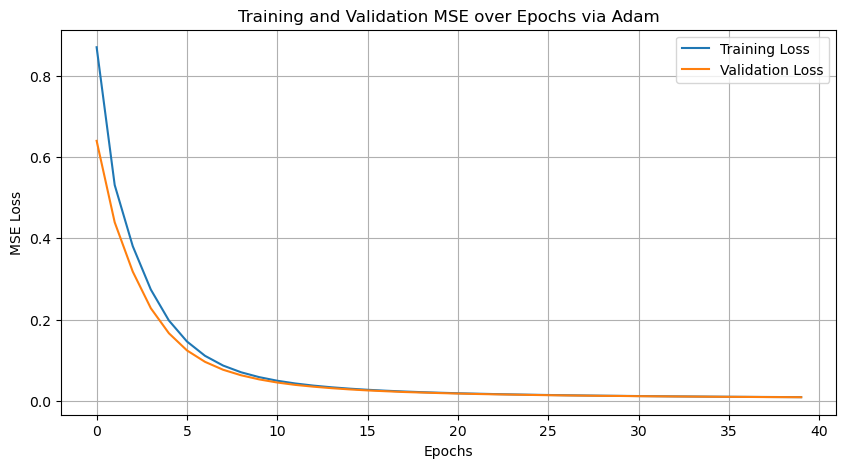

In [127]:
model_class = ConvAutoEncoder
in_dim = 1
lr = 0.0001
epochs_list = [50]
batch_size = 512
benchmark_mse = 0.0092


best_parameters = train(
        model_class=model_class,
        in_dim=in_dim,
        epochs_list=epochs_list,
        learning_rate=lr,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        batch_size=batch_size,
        benchmark_mse=benchmark_mse
    )


In [128]:
optimizer_name = min(best_parameters, key=lambda k: best_parameters[k]['min_loss'])
epochs = best_parameters[optimizer_name]['epoch']
model,_ = load_best_model(
    epochs,
    optimizer_name,
    model_class,
    in_dim,
    lr
)

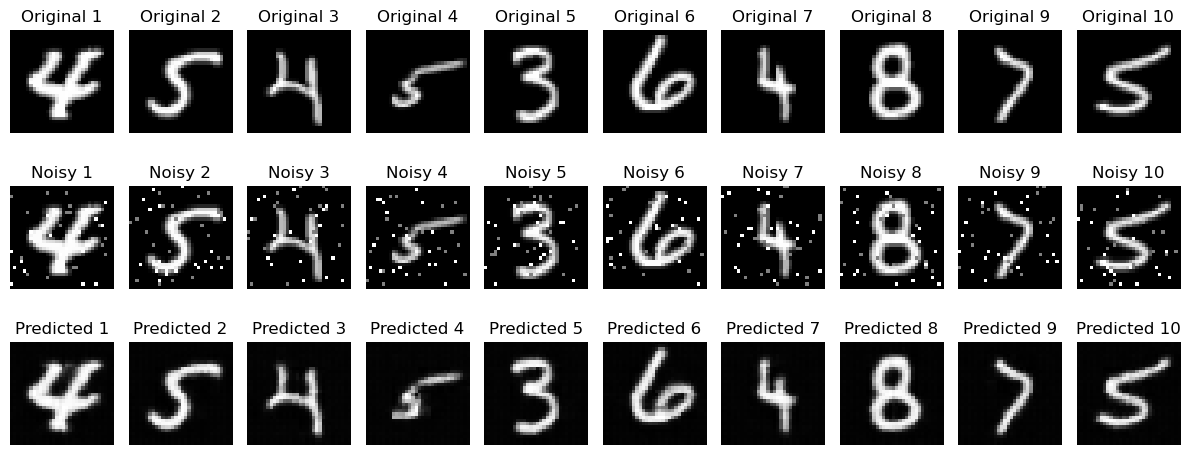

In [129]:
test_model(model, test_dataset)